# LSTM with embedding
Classify pc vs nc RNA.

Set aside the 20% test set, stratified by length.
On the remaining 80%,
perform 5-fold cross validation.

Use K=3. 
Use LSTM(16,16,16,1).

To do: 
Masking the Ns.
Either bidirectional RNN or try starting with the Ns.
Handle end case of max len < num K-mers.
K-mer embedding (like word2vec).

Build on RNN_10 which used an embedding.

Here:
Try embedding to a smaller dimension (16)
and use a simpler model (16 nodes).

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import ShuffleSplit

# from sklearn.preprocessing import OneHotEncoder

# For the manual cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

tf.keras.backend.set_floatx('float32')

EPOCHS=10
SPLITS=3
K=3

## Load and partition sequences

In [2]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)

def subset(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


In [3]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1:
            kmer=seq[i:i+K]
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [4]:
def do_cross_validation(X,y,K,maxlen,eps):
    cv_scores = []
    act="sigmoid"
    dt='float32'
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.2, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]
        print("BUILD MODEL")
        vocabulary_size=4**K+1   # 64 DNA K-mers at K=3
        embed_dimen=16

        rnn2 = keras.models.Sequential()
        embed_layer = keras.layers.Embedding(vocabulary_size,embed_dimen,input_length=maxlen);
        #embed_layer = keras.layers.Embedding(input_dim=input_features, output_dim=embed_dimensions);
        rnn1_layer = keras.layers.LSTM(16, return_sequences=True, 
                                   input_shape=[maxlen,embed_dimen])
        rnn2_layer = keras.layers.LSTM(16, return_sequences=True)
        rnn3_layer = keras.layers.LSTM(16, return_sequences=True)
        output_layer = keras.layers.SimpleRNN(1)

        rnn2.add(embed_layer)
        rnn2.add(rnn1_layer)
        rnn2.add(rnn2_layer)
        rnn2.add(rnn3_layer)
        rnn2.add(output_layer)

        bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
        print("COMPILE")
        rnn2.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
        print(rnn2.summary())  # really only need this once
        print("FIT")
        # this is complaining about string to float
        history=rnn2.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = rnn2.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (rnn2.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


In [5]:
nc_seq=load_fasta('ncRNA.fasta',0)
pc_seq=load_fasta('pcRNA.fasta',1)
all_seq=pd.concat((nc_seq,pc_seq),axis=0)

(train_set,test_set)=make_train_test(all_seq)
(X_test,y_test)=separate_X_and_y(test_set)

nc_seq=None
pc_seq=None
all_seq=None

In [6]:
def setup(MINLEN,MAXLEN,train_set):
    # Extract subset by length
    print("Subset %d - %d"%(MINLEN,MAXLEN))
    train_set=subset(train_set,MINLEN,MAXLEN)# One array to two: X and y
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    X_train_all
    print(type(X_train_all))
    print(X_train_all.shape)
    print(X_train_all.iloc[0])
    print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape

    print("transform...")
    # From pandas dataframe to numpy to list to numpy
    print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    print(type(X_train_kmers))
    print(X_train_kmers)

    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

## Len 200-1Kb


Subset 200 - 1000
original (30290, 4)
no short (30290, 4)
no long, no short (8879, 4)
<class 'pandas.core.frame.DataFrame'>
(8879, 1)
sequence    AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...
Name: 1280, dtype: object
348
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[12 46 54 ...  0  0  0]
 [ 9 36 14 ...  0  0  0]
 [34  7 28 ...  0  0  0]
 ...
 [37 19  9 ...  0  0  0]
 [57 36 15 ...  0  0  0]
 [33  3 12 ...  0  0  0]]
BUILD MODEL
COMPILE
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 16)          1040      
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 16)          2112      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 16)          2112      
_________________________________________

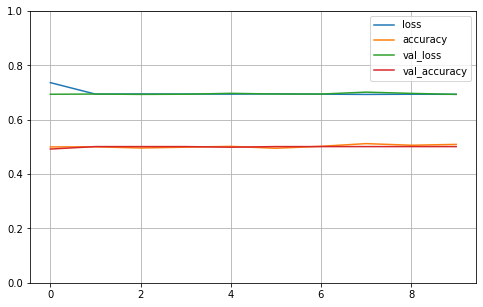

accuracy: 50.11%
BUILD MODEL
COMPILE
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 16)          1040      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 16)          2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 16)          2112      
_________________________________________________________________
lstm_5 (LSTM)                (None, 1000, 16)          2112      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1)                 18        
Total params: 7,394
Trainable params: 7,394
Non-trainable params: 0
_________________________________________________________________
None
FIT
Epoch 1/10
222/222 [==============================] - 386s 2s/step - los

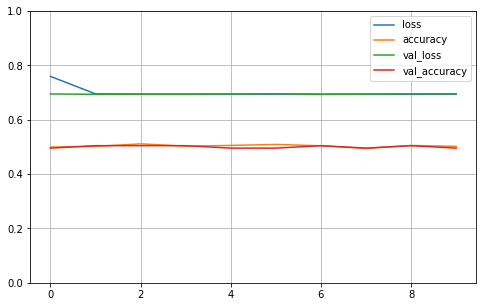

accuracy: 49.55%
BUILD MODEL
COMPILE
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 16)          1040      
_________________________________________________________________
lstm_6 (LSTM)                (None, 1000, 16)          2112      
_________________________________________________________________
lstm_7 (LSTM)                (None, 1000, 16)          2112      
_________________________________________________________________
lstm_8 (LSTM)                (None, 1000, 16)          2112      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 1)                 18        
Total params: 7,394
Trainable params: 7,394
Non-trainable params: 0
_________________________________________________________________
None
FIT
Epoch 1/10
222/222 [==============================] - 385s 2s/step - los

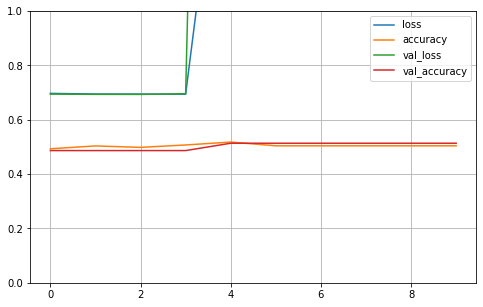

accuracy: 51.35%

Validation core mean 50.34% (+/- 0.75%)


In [7]:
MINLEN=200
MAXLEN=1000

(X_train,y_train)=setup(MINLEN,MAXLEN,train_set)
do_cross_validation(X_train,y_train,K,MAXLEN,EPOCHS)

## Len 1K-2Kb

Subset 1000 - 2000
original (30290, 4)
no short (9273, 4)
no long, no short (3368, 4)
<class 'pandas.core.frame.DataFrame'>
(3368, 1)
sequence    GGCGGGGTCGACTGACGGTAACGGGGCAGAGAGGCTGTTCGCAGAG...
Name: 12641, dtype: object
1338
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[42 39 27 ...  0  0  0]
 [57 34  5 ...  0  0  0]
 [27 44 47 ...  0  0  0]
 ...
 [44 47 57 ...  0  0  0]
 [10 37 20 ...  0  0  0]
 [47 60 48 ...  0  0  0]]
BUILD MODEL
COMPILE
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 16)          1040      
_________________________________________________________________
lstm_9 (LSTM)                (None, 2000, 16)          2112      
_________________________________________________________________
lstm_10 (LSTM)               (None, 2000, 16)          2112      
_____________________________________

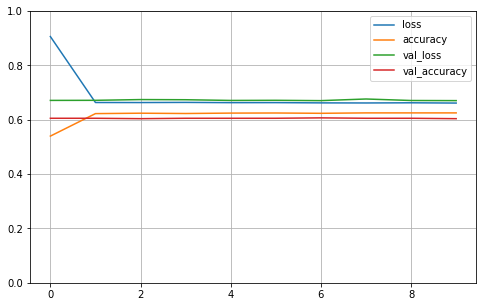

accuracy: 60.39%
BUILD MODEL
COMPILE
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2000, 16)          1040      
_________________________________________________________________
lstm_12 (LSTM)               (None, 2000, 16)          2112      
_________________________________________________________________
lstm_13 (LSTM)               (None, 2000, 16)          2112      
_________________________________________________________________
lstm_14 (LSTM)               (None, 2000, 16)          2112      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 1)                 18        
Total params: 7,394
Trainable params: 7,394
Non-trainable params: 0
_________________________________________________________________
None
FIT
Epoch 1/10
85/85 [==============================] - 318s 4s/step - loss:

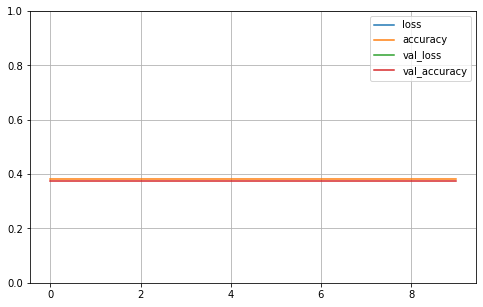

accuracy: 37.39%
BUILD MODEL
COMPILE
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2000, 16)          1040      
_________________________________________________________________
lstm_15 (LSTM)               (None, 2000, 16)          2112      
_________________________________________________________________
lstm_16 (LSTM)               (None, 2000, 16)          2112      
_________________________________________________________________
lstm_17 (LSTM)               (None, 2000, 16)          2112      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 1)                 18        
Total params: 7,394
Trainable params: 7,394
Non-trainable params: 0
_________________________________________________________________
None
FIT
Epoch 1/10
85/85 [==============================] - 313s 4s/step - loss:

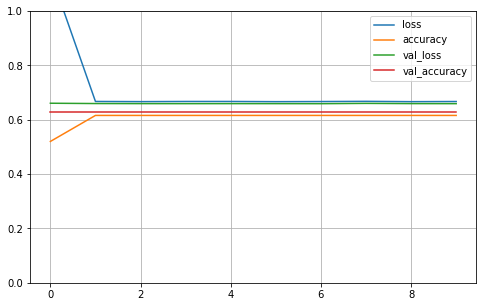

accuracy: 62.91%

Validation core mean 53.56% (+/- 11.48%)


In [8]:
MINLEN=1000
MAXLEN=2000
(X_train,y_train)=setup(MINLEN,MAXLEN,train_set)
do_cross_validation(X_train,y_train,K,MAXLEN,EPOCHS)

## Len 2K-3Kb

Subset 2000 - 3000
original (30290, 4)
no short (3221, 4)
no long, no short (1351, 4)
<class 'pandas.core.frame.DataFrame'>
(1351, 1)
sequence    GTCATTCTAGCTGCCTGCTGCCTCCGCAGCGTCCCCCCAGCTCTCC...
Name: 19713, dtype: object
2039
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[46 53 20 ...  0  0  0]
 [ 3 10 37 ...  0  0  0]
 [12 48 62 ...  0  0  0]
 ...
 [13 49  3 ...  0  0  0]
 [39 25 33 ...  0  0  0]
 [ 9 36 15 ...  0  0  0]]
BUILD MODEL
COMPILE
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 3000, 16)          1040      
_________________________________________________________________
lstm_18 (LSTM)               (None, 3000, 16)          2112      
_________________________________________________________________
lstm_19 (LSTM)               (None, 3000, 16)          2112      
_____________________________________

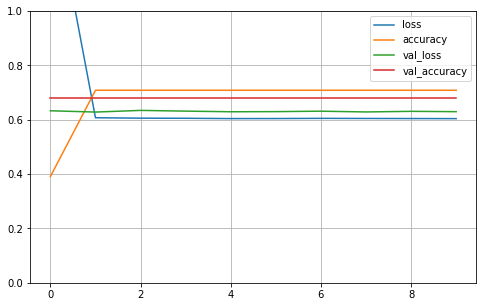

accuracy: 67.90%
BUILD MODEL
COMPILE
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 3000, 16)          1040      
_________________________________________________________________
lstm_21 (LSTM)               (None, 3000, 16)          2112      
_________________________________________________________________
lstm_22 (LSTM)               (None, 3000, 16)          2112      
_________________________________________________________________
lstm_23 (LSTM)               (None, 3000, 16)          2112      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 1)                 18        
Total params: 7,394
Trainable params: 7,394
Non-trainable params: 0
_________________________________________________________________
None
FIT
Epoch 1/10
34/34 [==============================] - 208s 6s/step - loss:

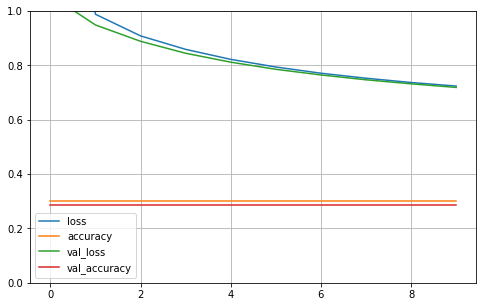

accuracy: 28.78%
BUILD MODEL
COMPILE
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 3000, 16)          1040      
_________________________________________________________________
lstm_24 (LSTM)               (None, 3000, 16)          2112      
_________________________________________________________________
lstm_25 (LSTM)               (None, 3000, 16)          2112      
_________________________________________________________________
lstm_26 (LSTM)               (None, 3000, 16)          2112      
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 1)                 18        
Total params: 7,394
Trainable params: 7,394
Non-trainable params: 0
_________________________________________________________________
None
FIT
Epoch 1/10
34/34 [==============================] - 205s 6s/step - loss:

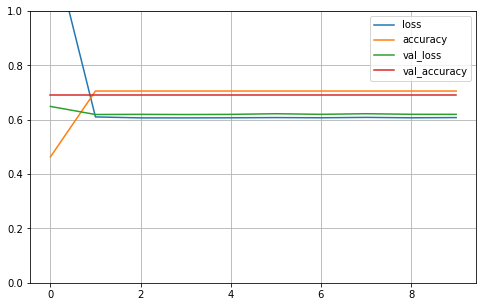

accuracy: 69.00%

Validation core mean 55.23% (+/- 18.71%)


In [9]:
MINLEN=2000
MAXLEN=3000
(X_train,y_train)=setup(MINLEN,MAXLEN,train_set)
do_cross_validation(X_train,y_train,K,MAXLEN,EPOCHS)